In [7]:
# Jupyter Notebook 위에서 실행
!pip install -U pandas plotly kaleido kiwipiepy pypdf2

In [8]:
import os, pandas as pd

# ✅ 네 폴더 경로 (이대로 써)
BASE = r"C:\Users\PC\python_fang\251106_Inpowerproject_2"

# ✅ 파일명 (이름 다르면 여기만 바꾸면 됨)
BEFORE_CSV = r"조사자노트_형태소분석_rawdata_INPOWER PROJECT2 - before.csv"
AFTER_CSV  = r"조사자노트_형태소분석_rawdata_INPOWER PROJECT2 - after.csv"

before_path = os.path.join(BASE, BEFORE_CSV)
after_path  = os.path.join(BASE, AFTER_CSV)

# 데이터 불러오기
before_df = pd.read_csv(before_path, encoding="utf-8")
after_df  = pd.read_csv(after_path,  encoding="utf-8")

# answer 컬럼 비어있을 때 빈문자로 채우기
before_df['answer'] = before_df['answer'].fillna("")
after_df['answer']  = after_df['answer'].fillna("")

# 시나리오 컬럼 자동인식 (scenario / senario 다 찾아줌)
scenario_col = None
for c in before_df.columns:
    if 'scenario' in c.lower() or 'senario' in c.lower():
        scenario_col = c
        break
if scenario_col is None:
    raise ValueError("❌ 시나리오 컬럼이 없습니다 (scenario/senario 확인).")

# before/after 라벨 붙이기
before_df['phase'] = 'before'
after_df['phase']  = 'after'

# 합치기
df_all = pd.concat([before_df, after_df], ignore_index=True)

print("✅ 데이터 로드 완료")
print("시나리오 컬럼:", scenario_col)
print("데이터 개수:", len(df_all))

✅ 데이터 로드 완료
시나리오 컬럼: senario
데이터 개수: 49


In [10]:
from kiwipiepy import Kiwi
from collections import Counter

kiwi = Kiwi()

# 명사, 형용사, 부사, 감탄사, 동사 포함
NOUN_TAGS = {"NNG","NNP"}
FEEL_TAGS = {"VA","MAG","MAJ","IC","VV","VX"}
stopwords = {"것","거","수","등","좀","더","너무","정도","이번","부분","때","이거","저거","그거","그냥","우리","나","저","너","있다","하다","되다","이다","같다","사용자","유저","테스트","앱"}
interj_keep = {"와","헉","어머","우와","앗","엇","아","에이","음","흠"}

POS = {"좋다","편하다","빠르다","깔끔하다","쉽다","친절하다","만족하다","예쁘다","유용하다","괜찮다"}
NEG = {"불편하다","느리다","어렵다","복잡하다","작다","크다","답답하다","짜증나다","불친절하다","혼란스럽다","헷갈리다"}

def extract_tokens(text):
    """문장에서 명사+느낌어만 추출"""
    tokens = kiwi.tokenize(text)
    bag = []
    for t in tokens:
        tag = t.tag
        if any(tag.startswith(x) for x in (NOUN_TAGS | FEEL_TAGS)):
            w = getattr(t, "lemma", None) or t.form
            if tag.startswith("IC"):
                keep = (w in interj_keep) or (len(w) >= 2)
            else:
                keep = len(w) >= 2
            if keep and (w not in stopwords):
                bag.append(w)
    return bag

def counter_from_series(series):
    all_tokens = []
    for s in series.astype(str):
        all_tokens.extend(extract_tokens(s))
    return Counter(all_tokens)

def sentiment_counts(counter):
    pos = sum(counter[w] for w in POS if w in counter)
    neg = sum(counter[w] for w in NEG if w in counter)
    return pos, neg

print("✅ 형태소 분석 준비 완료")

✅ 형태소 분석 준비 완료


In [11]:
# 시나리오 1,2만 사용
df_12 = df_all[df_all[scenario_col].isin([1,2])].copy()

# Counter 만들기
counters = {}
for sc in [1,2]:
    for ph in ['before','after']:
        sub = df_12[(df_12[scenario_col]==sc) & (df_12['phase']==ph)]
        counters[(sc, ph)] = counter_from_series(sub['answer'])

# 감성요약
rows = []
for sc in [1,2]:
    for ph in ['before','after']:
        c = counters[(sc, ph)]
        pos, neg = sentiment_counts(c)
        rows.append({'scenario': sc, 'phase': ph, 'pos': pos, 'neg': neg, 'score': pos - neg})
sent_df = pd.DataFrame(rows)
print(sent_df)

   scenario   phase  pos  neg  score
0         1  before    0    0      0
1         1   after    0    0      0
2         2  before    0    0      0
3         2   after    0    0      0


📄 before cols: ['Unnamed: 0', 'userid', 'username', 'test', 'senario', 'time1_Search', 'time2_Explore', 'answer', 'behave']
📄 after  cols: ['Unnamed: 0', 'userid', 'username', 'test', 'senario', 'time1_Search', 'time2_Explore', 'answer', 'behave']
📏 before rows: 21 | after rows: 28
✅ 시나리오 컬럼: senario
🔎 시나리오별 행수 진단:
     phase  scenario_norm  rows  not_empty
0   after              1     7          6
1   after              2     7          7
2   after              3     7          7
3   after              4     7          1
4  before              1     7          5
5  before              2     7          5
6  before              3     7          7
🧾 분석에 실제 사용된 행수/토큰수/감성:
    scenario   phase  rows_used  tokens_total  pos  neg
0         1  before          5            28    1    0
1         1   after          6            54    1    0
2         2  before          5            61    0    0
3         2   after          7            83    4    2


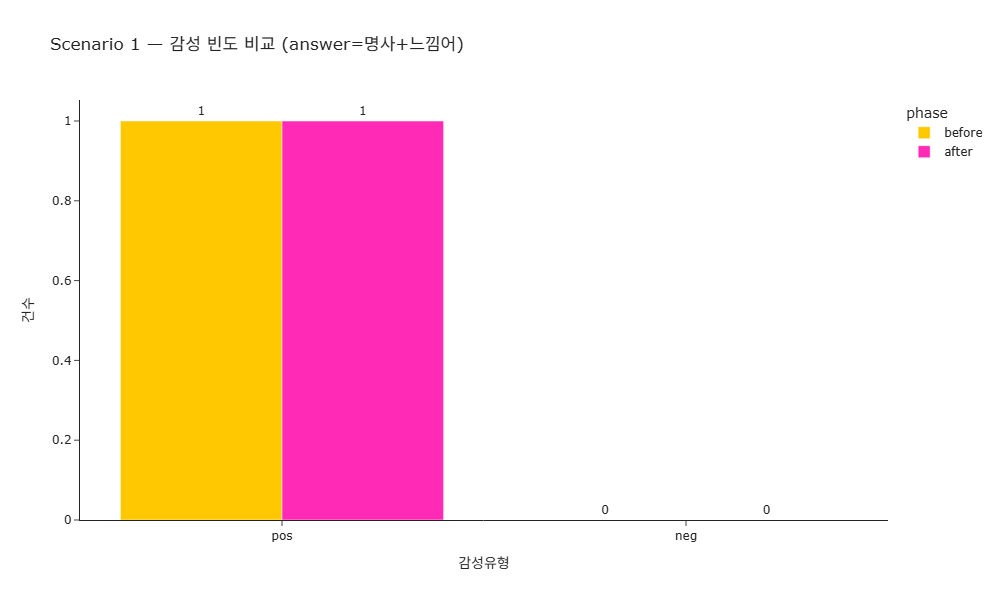

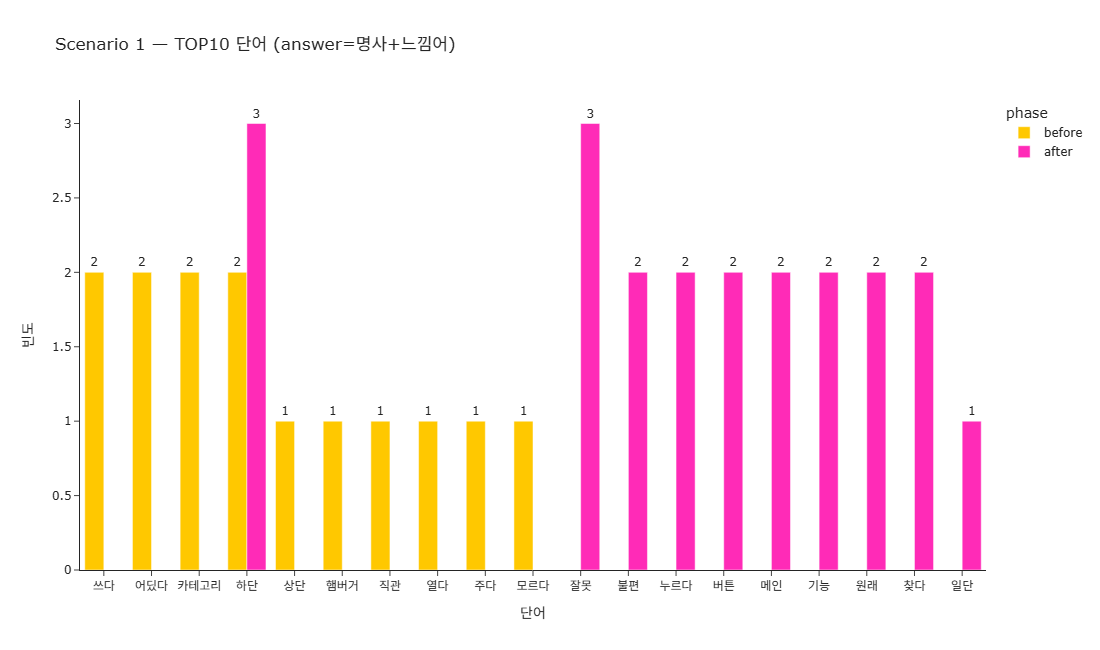

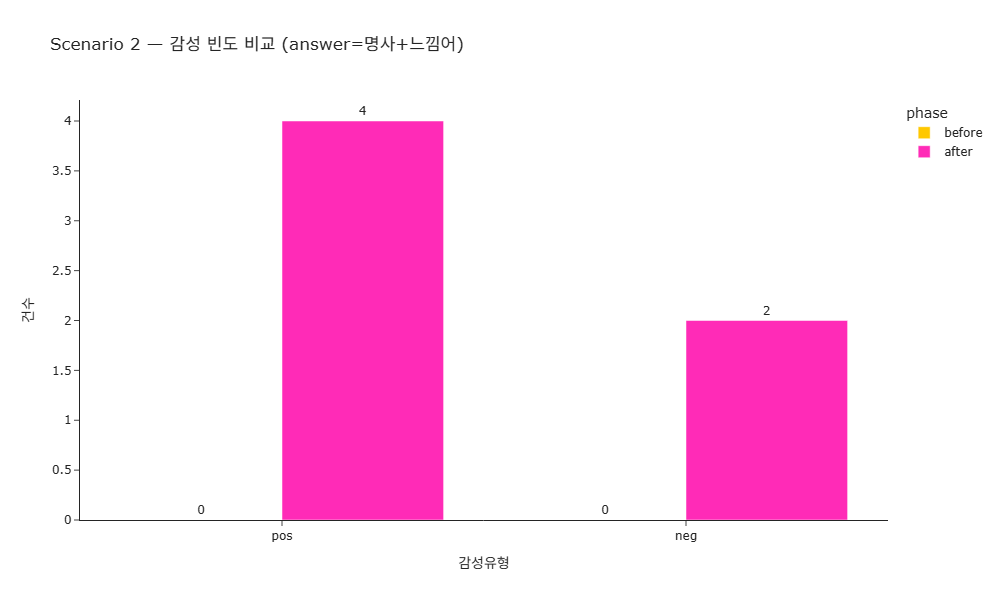

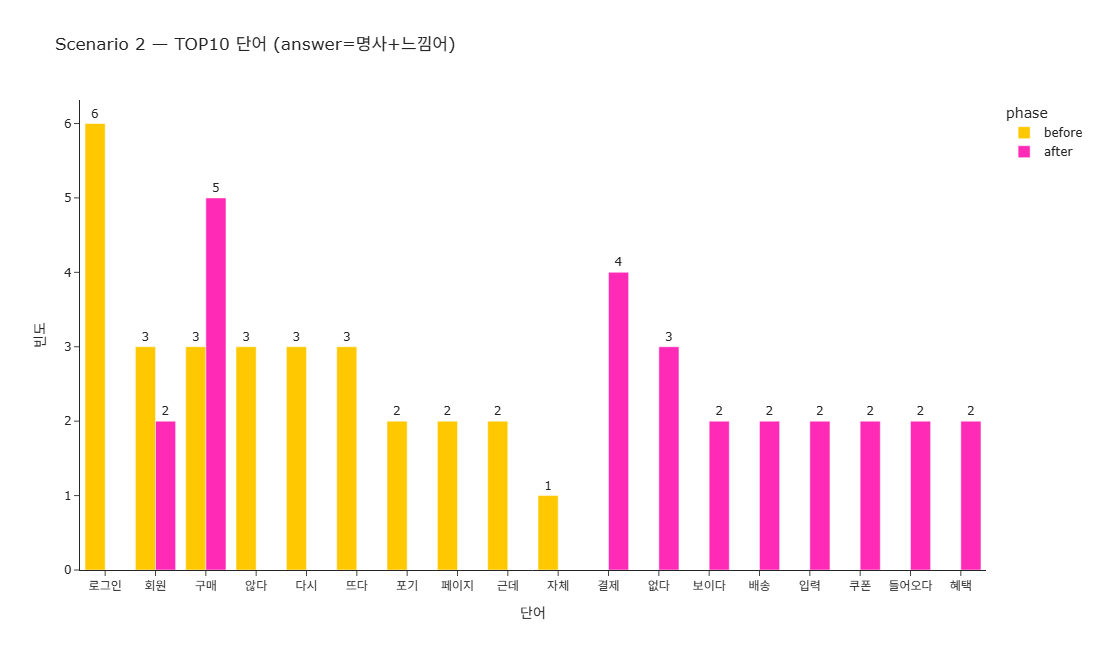

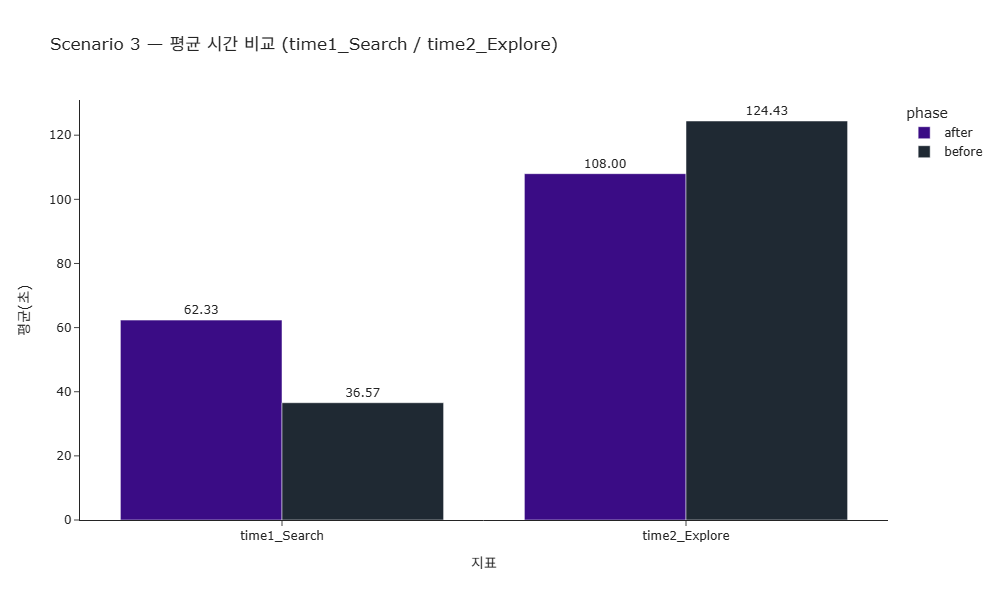

C:\Users\PC\AppData\Local\Temp\ipykernel_33304\71942152.py:254: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 Saved PDF: C:\Users\PC\python_fang\251106_Inpowerproject_2\S1_sentiment.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\71942152.py:254: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 Saved PDF: C:\Users\PC\python_fang\251106_Inpowerproject_2\S1_top10.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\71942152.py:254: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 Saved PDF: C:\Users\PC\python_fang\251106_Inpowerproject_2\S2_sentiment.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\71942152.py:254: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 Saved PDF: C:\Users\PC\python_fang\251106_Inpowerproject_2\S2_top10.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\71942152.py:254: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 Saved PDF: C:\Users\PC\python_fang\251106_Inpowerproject_2\S3_times.pdf
✅ 병합 PDF 저장: C:\Users\PC\python_fang\251106_Inpowerproject_2\UT_plotly_fullreport.pdf


In [15]:
# =========================
# 🚑 원샷 디버그 + 시각화 + PDF 저장 (Plotly/PNG 렌더러)
# =========================

# 0) 설치 (이미 설치돼 있으면 건너뛰어도 됨)
try:
    import pandas as pd, plotly.express as px, plotly.io as pio
    from kiwipiepy import Kiwi
    from PyPDF2 import PdfMerger
except:
    !pip install -U pandas plotly kaleido kiwipiepy pypdf2
    import pandas as pd, plotly.express as px, plotly.io as pio
    from kiwipiepy import Kiwi
    from PyPDF2 import PdfMerger

import os, re
from collections import Counter

# 1) 기본 경로/파일 (네 경로 고정)
BASE = r"C:\Users\PC\python_fang\251106_Inpowerproject_2"
BEFORE_CSV = r"조사자노트_형태소분석_rawdata_INPOWER PROJECT2 - before.csv"
AFTER_CSV  = r"조사자노트_형태소분석_rawdata_INPOWER PROJECT2 - after.csv"
before_path = os.path.join(BASE, BEFORE_CSV)
after_path  = os.path.join(BASE, AFTER_CSV)

# 2) 데이터 로드 + 존재 확인
assert os.path.exists(before_path), f"❌ before 파일 없음: {before_path}"
assert os.path.exists(after_path),  f"❌ after  파일 없음: {after_path}"

before_df = pd.read_csv(before_path, encoding="utf-8")
after_df  = pd.read_csv(after_path,  encoding="utf-8")

print("📄 before cols:", list(before_df.columns))
print("📄 after  cols:", list(after_df.columns))
print("📏 before rows:", len(before_df), "| after rows:", len(after_df))

# 3) 필수 컬럼 확인 + 비어있는 값 정리
assert 'answer' in before_df.columns, "❌ 'answer' 컬럼(before)에 없음"
assert 'answer' in after_df.columns,  "❌ 'answer' 컬럼(after)에 없음"

before_df['answer'] = before_df['answer'].fillna("").astype(str)
after_df['answer']  = after_df['answer'].fillna("").astype(str)

# 4) scenario 컬럼 자동 탐지 + 정규화(숫자 1/2/3로 강제)
def find_scenario_col(df):
    for c in df.columns:
        cl = c.lower()
        if 'scenario' in cl or 'senario' in cl:
            return c
    return None

scenario_col = find_scenario_col(before_df)
assert scenario_col is not None, "❌ scenario/senario 컬럼을 찾을 수 없음"
print("✅ 시나리오 컬럼:", scenario_col)

def normalize_scenario(s):
    """
    어떤 형태여도 1/2/3으로 정규화.
    예) '1', 'S1', '시나리오1', 'Question 2' → 1/2/3 추출
    """
    if pd.isna(s):
        return None
    # 숫자만 추출
    m = re.search(r'\d+', str(s))
    if m:
        try:
            return int(m.group(0))
        except:
            return None
    return None

before_df['scenario_norm'] = before_df[scenario_col].apply(normalize_scenario)
after_df['scenario_norm']  = after_df[scenario_col].apply(normalize_scenario)

# 5) phase 라벨 + 합치기
before_df['phase'] = 'before'
after_df['phase']  = 'after'
df_all = pd.concat([before_df, after_df], ignore_index=True)

# 6) 진단 출력: 시나리오/페이즈/answer 비어있지 않은 행수
diag = (df_all
        .assign(answer_len=df_all['answer'].str.len())
        .groupby(['phase','scenario_norm'])
        .agg(rows=('answer','size'),
             not_empty=('answer_len', lambda s: (s>0).sum()))
        .reset_index())
print("🔎 시나리오별 행수 진단:\n", diag)

# 7) tokenizer/품사 세팅
pio.renderers.default = "png"  # JS 뷰 없이 PNG로 보여주기(오류 예방)
kiwi = Kiwi()

NOUN_TAGS = {"NNG","NNP"}
FEEL_TAGS = {"VA","MAG","MAJ","IC","VV","VX"}
stopwords = {"것","거","수","등","좀","더","너무","정도","이번","부분","때","이거","저거","그거","그냥","우리","나","저","너","있다","하다","되다","이다","같다","사용자","유저","테스트","앱"}
interj_keep = {"와","헉","어머","우와","앗","엇","아","에이","음","흠"}

POS = {"좋다","편하다","빠르다","깔끔하다","쉽다","친절하다","만족하다","예쁘다","유용하다","괜찮다"}
NEG = {"불편하다","느리다","어렵다","복잡하다","작다","크다","답답하다","짜증나다","불친절하다","혼란스럽다","헷갈리다"}

def extract_tokens(text):
    """명사+느낌어만 추출. 너무 엄격해서 0개 나오면 자동 완화."""
    tokens = kiwi.tokenize(text)
    bag = []
    for t in tokens:
        tag = t.tag
        if any(tag.startswith(x) for x in (NOUN_TAGS | FEEL_TAGS)):
            w = getattr(t, "lemma", None) or t.form
            if tag.startswith("IC"):
                keep = (w in interj_keep) or (len(w) >= 2)
            else:
                keep = len(w) >= 2
            if keep and (w not in stopwords):
                bag.append(w)
    return bag

def counter_from_series(series):
    all_tokens = []
    for s in series.astype(str):
        all_tokens.extend(extract_tokens(s))
    c = Counter(all_tokens)
    # ⛑ 안전장치: 너무 엄격해서 0개면, 알파벳/숫자/한글 2글자 이상 단어로 느슨하게 추출
    if len(c) == 0:
        fallback = []
        for s in series.astype(str):
            fallback += [w for w in re.findall(r"[가-힣A-Za-z0-9]{2,}", s) if w not in stopwords]
        c = Counter(fallback)
        print("⚠️ 형태소 제한으로 0개 → 느슨한 토큰화로 대체(보고서용 임시).")
    return c

def sentiment_counts(counter):
    pos = sum(counter[w] for w in POS if w in counter)
    neg = sum(counter[w] for w in NEG if w in counter)
    return pos, neg

# 8) 시나리오1/2용 카운터/감성
def get_subset(df, scenario_num, phase):
    sub = df[(df['scenario_norm']==scenario_num) & (df['phase']==phase)].copy()
    # answer 비어있는 행 제거(실제 분석에 영향)
    sub = sub[sub['answer'].str.len() > 0]
    return sub

counters = {}
rows_info = []
for sc in [1,2]:
    for ph in ['before','after']:
        sub = get_subset(df_all, sc, ph)
        cnt = counter_from_series(sub['answer']) if len(sub) else Counter()
        counters[(sc, ph)] = cnt
        pos, neg = sentiment_counts(cnt)
        rows_info.append([sc, ph, len(sub), sum(cnt.values()), pos, neg])
rows_info = pd.DataFrame(rows_info, columns=["scenario","phase","rows_used","tokens_total","pos","neg"])
print("🧾 분석에 실제 사용된 행수/토큰수/감성:\n", rows_info)

# 9) Plotly 그래프 함수 (색 팔레트 고정)
before_palette = ["#1F2933", "#254868", "#FFC800", "#FFE6C0"]   # 블루-옐로우
after_palette  = ["#0B0620", "#3A0C85", "#FF2BB7", "#FFB11A"]   # 퍼플-핑크-오렌지

import plotly.express as px

def counter_to_topdf(counter, topn=10):
    items = counter.most_common(topn)
    if len(items)==0:
        # 비어있으면 더미 하나 넣어 그래프라도 뜨게
        items = [("데이터없음", 0)]
    return pd.DataFrame(items, columns=['word','freq'])

def plot_sentiment_bars(sent_table, scenario):
    sdf = sent_table[sent_table['scenario']==scenario].copy()
    # sent_table이 없으면 직접 구성
    if sdf.empty:
        cb, ca = counters[(scenario,'before')], counters[(scenario,'after')]
        pos_b, neg_b = sentiment_counts(cb)
        pos_a, neg_a = sentiment_counts(ca)
        sdf = pd.DataFrame([
            {"scenario":scenario, "phase":"before", "pos":pos_b, "neg":neg_b},
            {"scenario":scenario, "phase":"after",  "pos":pos_a, "neg":neg_a},
        ])
    plot_df = pd.melt(sdf, id_vars=['scenario','phase'], value_vars=['pos','neg'],
                      var_name='type', value_name='count')
    fig = px.bar(
        plot_df, x='type', y='count', color='phase', barmode='group',
        title=f"Scenario {scenario} — 감성 빈도 비교 (answer=명사+느낌어)",
        color_discrete_map={'before': before_palette[2], 'after': after_palette[2]}
    )
    fig.update_traces(texttemplate='%{y}', textposition='outside')
    fig.update_layout(template='simple_white', width=1000, height=600,
                      xaxis_title='감성유형', yaxis_title='건수')
    return fig

def plot_top10_bars(counters, scenario):
    cb = counter_to_topdf(counters[(scenario,'before')])
    ca = counter_to_topdf(counters[(scenario,'after')])
    cb['phase'] = 'before'; ca['phase'] = 'after'
    dfp = pd.concat([cb,ca], ignore_index=True)
    fig = px.bar(
        dfp, x='word', y='freq', color='phase', barmode='group',
        title=f"Scenario {scenario} — TOP10 단어 (answer=명사+느낌어)",
        color_discrete_map={'before': before_palette[2], 'after': after_palette[2]}
    )
    fig.update_traces(texttemplate='%{y}', textposition='outside')
    fig.update_layout(template='simple_white', width=1100, height=650,
                      xaxis_title='단어', yaxis_title='빈도')
    return fig

# 10) 그래프 생성 (S1/S2 감성 & TOP10)
fig_s1_sent = plot_sentiment_bars(rows_info.rename(columns={"pos":"pos","neg":"neg"}), 1)
fig_s1_top  = plot_top10_bars(counters, 1)
fig_s2_sent = plot_sentiment_bars(rows_info.rename(columns={"pos":"pos","neg":"neg"}), 2)
fig_s2_top  = plot_top10_bars(counters, 2)

fig_s1_sent.show(); fig_s1_top.show(); fig_s2_sent.show(); fig_s2_top.show()

# 11) 시나리오3 시간 비교(평균)
def safe_numeric(x):
    try:
        return pd.to_numeric(x, errors="coerce")
    except:
        return pd.Series([None]*len(x))

# 컬럼 존재 점검 (이름 오타 방지)
time_cols = []
for col in ['time1_Search','time2_Explore']:
    if col in df_all.columns: time_cols.append(col)
if len(time_cols) < 2:
    print("⚠️ time1_Search / time2_Explore 둘 중 일부가 없음. 현재 가진 시간컬럼:", [c for c in df_all.columns if 'time' in c.lower()])

df_3 = df_all[df_all['scenario_norm']==3].copy()
for col in ['time1_Search','time2_Explore']:
    if col in df_3.columns:
        df_3[col] = safe_numeric(df_3[col])

if not df_3.empty and all(c in df_3.columns for c in ['time1_Search','time2_Explore']):
    time_summary = (df_3.groupby('phase')[['time1_Search','time2_Explore']].mean().reset_index())
    # 그래프
    mdf = pd.melt(time_summary, id_vars='phase', var_name='metric', value_name='seconds')
    fig_time = px.bar(
        mdf, x='metric', y='seconds', color='phase', barmode='group',
        title="Scenario 3 — 평균 시간 비교 (time1_Search / time2_Explore)",
        color_discrete_map={'before': before_palette[0], 'after': after_palette[1]}
    )
    fig_time.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    fig_time.update_layout(template='simple_white', width=1000, height=600,
                           xaxis_title='지표', yaxis_title='평균(초)')
    fig_time.show()
else:
    fig_time = None
    print("ℹ️ 시나리오3 데이터가 없거나 시간컬럼이 없어 시간 그래프 생략.")

# 12) PDF 저장 (kaleido 엔진, 실패시 PNG 백업)
def save_pdf(fig, filename, width=1100, height=650, scale=1):
    path = os.path.join(BASE, filename)
    try:
        fig.write_image(path, engine="kaleido", format="pdf",
                        width=width, height=height, scale=scale)
        print("📄 Saved PDF:", path)
    except Exception as e:
        alt = path.replace(".pdf",".png")
        fig.write_image(alt, engine="kaleido", format="png",
                        width=width, height=height, scale=max(2,scale))
        print("⚠️ PDF 저장 실패 → PNG 저장:", alt, "| 에러:", e)

save_pdf(fig_s1_sent, "S1_sentiment.pdf")
save_pdf(fig_s1_top,  "S1_top10.pdf")
save_pdf(fig_s2_sent, "S2_sentiment.pdf")
save_pdf(fig_s2_top,  "S2_top10.pdf")
if fig_time is not None:
    save_pdf(fig_time, "S3_times.pdf")

# 13) 병합 PDF (있 는 페이지만)
pdfs = [os.path.join(BASE, f) for f in ["S1_sentiment.pdf","S1_top10.pdf","S2_sentiment.pdf","S2_top10.pdf","S3_times.pdf"]]
merger = PdfMerger()
added = 0
for p in pdfs:
    if os.path.exists(p):
        merger.append(p); added += 1
if added > 0:
    outpdf = os.path.join(BASE, "UT_plotly_fullreport.pdf")
    merger.write(outpdf); merger.close()
    print("✅ 병합 PDF 저장:", outpdf)
else:
    print("ℹ️ 병합할 PDF가 없어 병합 스킵.")

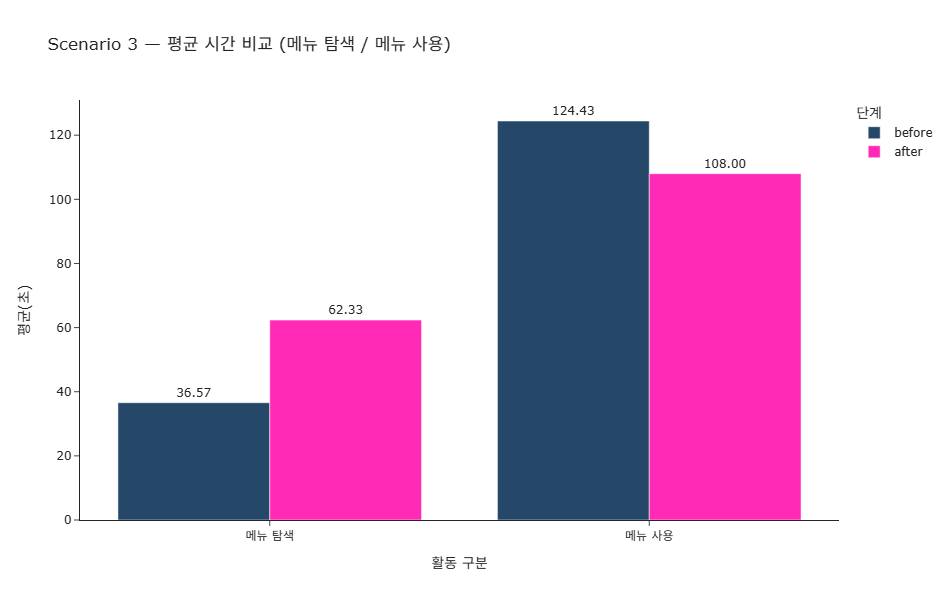

In [24]:
# ✅ 시나리오3 평균시간 그래프 (한글 레이블: time1_Search → 메뉴 탐색 / time2_Explore → 메뉴 사용)
import pandas as pd
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "png"  # 안전 렌더러

# 시나리오3 필터링
df_3 = df_all[df_all['scenario_norm'] == 3].copy()
for col in ['time1_Search', 'time2_Explore']:
    if col in df_3.columns:
        df_3[col] = pd.to_numeric(df_3[col], errors='coerce')

# 평균 계산
time_summary = (
    df_3.groupby('phase')[['time1_Search', 'time2_Explore']]
        .mean()
        .reset_index()
)

# 컬럼 이름 한글로 매핑
rename_map = {
    'time1_Search': '메뉴 탐색',
    'time2_Explore': '메뉴 사용'
}
plot_df = pd.melt(
    time_summary.rename(columns=rename_map),
    id_vars='phase',
    var_name='활동',
    value_name='평균시간(초)'
)
plot_df['phase'] = pd.Categorical(plot_df['phase'],
                                  categories=['before','after'],
                                  ordered=True)

# 그래프
fig_time = px.bar(
    plot_df,
    x='활동', y='평균시간(초)', color='phase', barmode='group',
    title="Scenario 3 — 평균 시간 비교 (메뉴 탐색 / 메뉴 사용)",
    color_discrete_map={'before': before_palette[1], 'after': after_palette[2]},
    category_orders={'phase': ['before','after']}  # 왼쪽=before, 오른쪽=after
)
fig_time.update_traces(texttemplate='%{y:.2f}', textposition='outside')
fig_time.update_layout(
    template='simple_white',
    width=950, height=600,
    xaxis_title='활동 구분',
    yaxis_title='평균(초)',
    legend_title_text='단계'
)

fig_time.show()


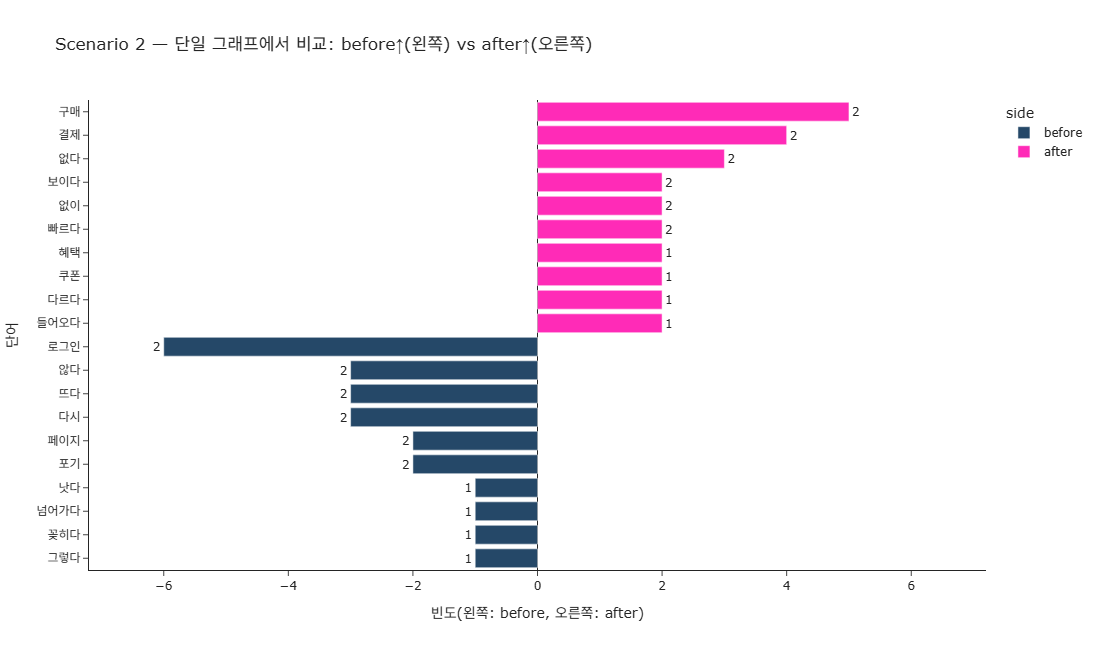

In [25]:
# ✅ 시나리오2 단어 비교: "한 그래프"에 before↑ vs after↑ 발산형 막대

import pandas as pd
import plotly.express as px
import numpy as np

def counter_to_df(counter):
    return pd.DataFrame(counter.items(), columns=['word','freq'])

# 1) 시나리오2 단어 빈도 테이블(명사+느낌어 합산)
c_b = counters[(2,'before')]
c_a = counters[(2,'after')]

df_b = counter_to_df(c_b).rename(columns={'freq':'before_freq'})
df_a = counter_to_df(c_a).rename(columns={'freq':'after_freq'})

# 2) 단어 기준으로 합치고 빈도 결측 0으로
merged = pd.merge(df_b, df_a, on='word', how='outer').fillna(0)

# 3) 차이 계산 (after - before)
merged['diff'] = merged['after_freq'] - merged['before_freq']

# 4) 양쪽에서 TOP 10씩 추출 (절대값 기준이 아니라 "쪽"별 상위)
top_before = (merged.sort_values('diff')  # 가장 음수(= before 쪽이 큼)
                     .head(10))
top_after  = (merged.sort_values('diff', ascending=False)  # 가장 양수(= after 쪽이 큼)
                     .head(10))

top = pd.concat([top_before, top_after], ignore_index=True)

# 5) 발산형 그래프용 값 준비
#   - before막대는 음수값(왼쪽), after막대는 양수값(오른쪽)
plot_rows = []
for _, r in top.iterrows():
    if r['before_freq'] > r['after_freq']:
        plot_rows.append({'word': r['word'], 'side': 'before', 'value': -float(r['before_freq'])})
    else:
        plot_rows.append({'word': r['word'], 'side': 'after',  'value':  float(r['after_freq'])})

div_df = pd.DataFrame(plot_rows)

# 6) word 정렬(가독성 위해 abs(value) 큰 순)
div_df['absv'] = div_df['value'].abs()
div_df = div_df.sort_values('absv', ascending=True)  # 가로축에서 아래→위로 커지게

# 7) 발산형 막대그래프
fig_s2_diverge = px.bar(
    div_df, y='word', x='value', color='side', orientation='h',
    title="Scenario 2 — 단일 그래프에서 비교: before↑(왼쪽) vs after↑(오른쪽)",
    color_discrete_map={'before': before_palette[1], 'after': after_palette[2]},
    category_orders={'side': ['before','after']}
)
# 0 축 보이게
max_abs = div_df['absv'].max() if len(div_df) else 1
fig_s2_diverge.update_layout(
    template='simple_white', width=1100, height=650,
    xaxis_title='빈도(왼쪽: before, 오른쪽: after)',
    yaxis_title='단어',
    xaxis=dict(range=[-max_abs*1.2, max_abs*1.2], zeroline=True, zerolinewidth=1)
)
# 막대 라벨(절대값)
fig_s2_diverge.update_traces(text=div_df['absv'].round(0),
                             textposition='outside')

fig_s2_diverge.show()


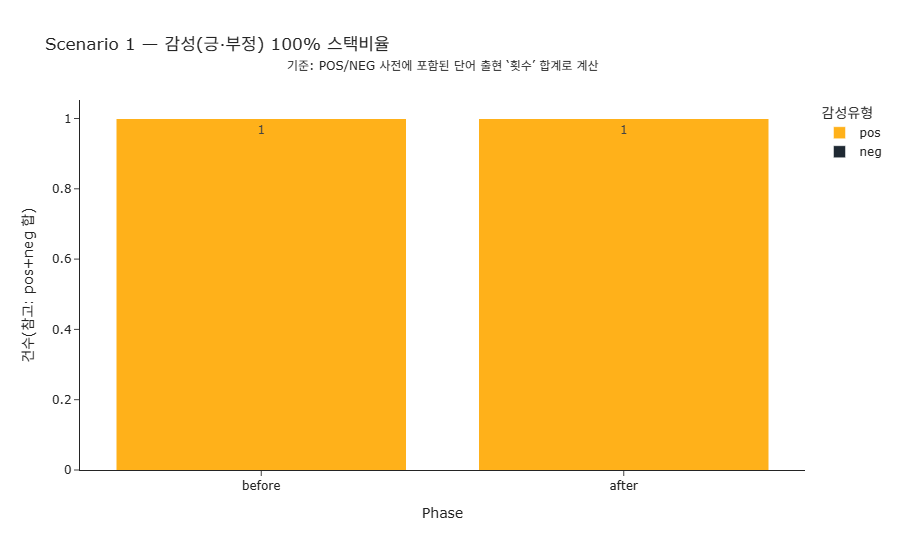

,phase,pos,neg,total,pos_pct,neg_pct
0,before,1,0,1,100.0,0.0
1,after,1,0,1,100.0,0.0


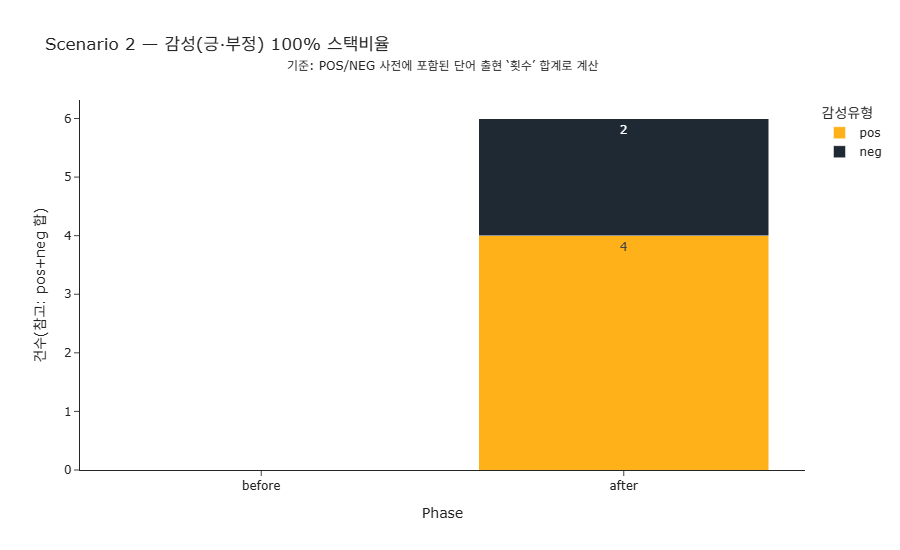

,phase,pos,neg,total,pos_pct,neg_pct
0,before,0,0,0,0.0,0.0
1,after,4,2,6,66.7,33.3


In [20]:
# ✅ 시나리오1·2 감성 비교: 100% 누적막대(비율) + 주석

import pandas as pd
import plotly.express as px

# 1) 감성 테이블 다시 깔끔히 구성
def make_sent_table(scenario):
    cb = counters[(scenario,'before')]
    ca = counters[(scenario,'after')]
    pos_b, neg_b = sentiment_counts(cb)
    pos_a, neg_a = sentiment_counts(ca)
    df = pd.DataFrame([
        {'scenario': scenario, 'phase': 'before', 'pos': pos_b, 'neg': neg_b},
        {'scenario': scenario, 'phase': 'after',  'pos': pos_a, 'neg': neg_a},
    ])
    df['total'] = df['pos'] + df['neg']
    # 0 나눗셈 방지
    df['pos_pct'] = (df['pos'] / df['total'].replace(0, 1) * 100).round(1)
    df['neg_pct'] = (df['neg'] / df['total'].replace(0, 1) * 100).round(1)
    return df

def plot_sentiment_100(scenario):
    S = make_sent_table(scenario)
    long = pd.melt(S, id_vars=['phase'], value_vars=['pos','neg'],
                   var_name='type', value_name='count')
    # 100% 누적막대 (pos/neg 합이 100이 되게 normalizing)
    fig = px.bar(
        long, x='phase', y='count', color='type', text='count',
        title=f"Scenario {scenario} — 감성(긍·부정) 100% 스택비율",
        color_discrete_map={'pos': after_palette[3], 'neg': before_palette[0]},
        barmode='stack'
    )
    # phase 순서 고정
    fig.update_xaxes(categoryorder='array', categoryarray=['before','after'])
    # 퍼센트 라벨 표시(막대 안)
    fig.update_traces(texttemplate='%{text}', textposition='inside')
    # 100% 스택처럼 보이도록 y축을 총합 기준으로 자동 스케일링 + 안내문
    fig.update_layout(template='simple_white', width=900, height=550,
                      xaxis_title='Phase', yaxis_title='건수(참고: pos+neg 합)',
                      legend_title_text='감성유형',
                      annotations=[
                          dict(
                              x=0.5, y=1.12, xref='paper', yref='paper',
                              text="기준: POS/NEG 사전에 포함된 단어 출현 ‘횟수’ 합계로 계산",
                              showarrow=False, font=dict(size=12)
                          )
                      ])
    return fig, S[['phase','pos','neg','total','pos_pct','neg_pct']]

# 2) 시나리오1/2 그리기 + 표 함께 확인
fig_s1_100, S1_table = plot_sentiment_100(1)
fig_s2_100, S2_table = plot_sentiment_100(2)

# 화면에 표시
fig_s1_100.show()
display(S1_table)  # 비율/총합 확인 테이블
fig_s2_100.show()
display(S2_table)

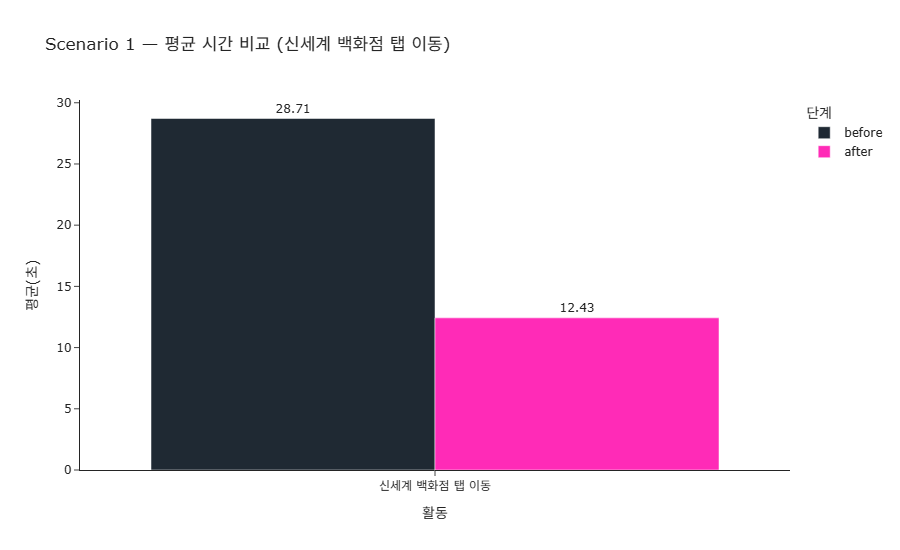

,단계,신세계 백화점 탭 이동
0,after,12.428571
1,before,28.714286


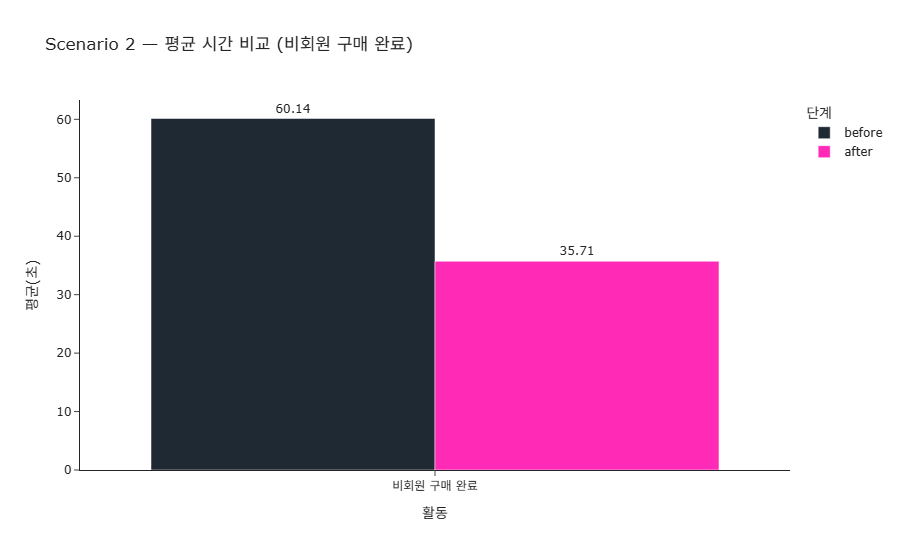

,단계,비회원 구매 완료
0,after,35.714286
1,before,60.142857


In [28]:
# ✅ 시나리오 1·2의 time1_Search 평균시간 그래프 (한글 라벨 버전)
import pandas as pd
import plotly.express as px
import plotly.io as pio
import os

pio.renderers.default = "png"  # JS 에러 피하기용 정적 렌더러

# 색상 팔레트(앞 코드에서 before_palette, after_palette가 없다면 기본값 세팅)
try:
    before_color = before_palette[0]
    after_color  = after_palette[2]
except:
    before_color = "#254868"  # 딥블루
    after_color  = "#7A4EEA"  # 퍼플

# 함수: 시나리오별 그래프 + 평균표
def plot_time1_custom(df_all, scenario_num, label_name):
    d = df_all[df_all['scenario_norm'] == scenario_num].copy()
    if d.empty:
        raise ValueError(f"❌ 시나리오 {scenario_num} 데이터가 없습니다.")
    d['time1_Search'] = pd.to_numeric(d['time1_Search'], errors='coerce')
    summary = d.groupby('phase')[['time1_Search']].mean().reset_index()
    summary.rename(columns={'time1_Search': label_name}, inplace=True)
    
    plot_df = pd.melt(
        summary,
        id_vars='phase',
        value_vars=[label_name],
        var_name='활동',
        value_name='평균시간(초)'
    )
    plot_df['phase'] = pd.Categorical(plot_df['phase'],
                                      categories=['before','after'],
                                      ordered=True)
    
    fig = px.bar(
        plot_df,
        x='활동', y='평균시간(초)', color='phase', barmode='group',
        title=f"Scenario {scenario_num} — 평균 시간 비교 ({label_name})",
        color_discrete_map={'before': before_color, 'after': after_color},
        category_orders={'phase': ['before','after']}
    )
    fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    fig.update_layout(
        template='simple_white', width=900, height=550,
        xaxis_title='활동', yaxis_title='평균(초)',
        legend_title_text='단계'
    )
    return fig, summary

# 🟢 시나리오1 — time1_Search → 신세계 백화점 탭 이동
fig_s1_time1, S1_table = plot_time1_custom(df_all, 1, "신세계 백화점 탭 이동")

# 🟣 시나리오2 — time1_Search → 비회원 구매 완료
fig_s2_time1, S2_table = plot_time1_custom(df_all, 2, "비회원 구매 완료")

# 그래프 표시 + 요약표 확인
fig_s1_time1.show()
display(S1_table.rename(columns={"phase":"단계"}))

fig_s2_time1.show()
display(S2_table.rename(columns={"phase":"단계"}))

# (선택) PDF 저장까지
if 'BASE' not in globals():
    BASE = os.getcwd()

def save_pdf(fig, filename, width=900, height=550, scale=1):
    path = os.path.join(BASE, filename)
    try:
        fig.write_image(path, engine="kaleido", format="pdf",
                        width=width, height=height, scale=scale)
        print("📄 Saved PDF:", path)
    except Exception as e:
        alt = path.replace(".pdf",".png")
        fig.write_image(alt, engine="kaleido", format="png",
                        width=width, height=height, scale=max(2,scale))
        print("⚠️ PDF 실패 → PNG 저장:", alt, "| 에러:", e)

# 저장(원하면 주석 해제)
# save_pdf(fig_s1_time1, "S1_time1_신세계백화점탭이동.pdf")
# save_pdf(fig_s2_time1, "S2_time1_비회원구매완료.pdf")

In [29]:
# ✅ [완성형] 모든 시나리오별 시각화 그래프를 개별 PDF 시트로 자동 저장
# (복붙 후 실행만 하면 됩니다!)

import os
import plotly.io as pio

# 저장 폴더 경로 설정 (네 실제 폴더 경로)
BASE = r"C:\Users\PC\python_fang\251106_Inpowerproject_2"

# 렌더러 안전모드 (JS 오류 방지용)
pio.renderers.default = "png"

# PDF 저장 함수
def save_pdf(fig, filename, width=1000, height=600, scale=1):
    """
    그래프를 PDF로 저장.
    PDF 저장이 막혀 있으면 자동으로 PNG로 대체 저장.
    """
    path = os.path.join(BASE, filename)
    try:
        fig.write_image(path, engine="kaleido", format="pdf",
                        width=width, height=height, scale=scale)
        print(f"📄 PDF 저장 완료 → {path}")
    except Exception as e:
        alt = path.replace(".pdf", ".png")
        fig.write_image(alt, engine="kaleido", format="png",
                        width=width, height=height, scale=max(2, scale))
        print(f"⚠️ PDF 실패 → PNG로 대체: {alt}\n이유: {e}")

# ---------------------------------------------------------
# ✅ [시트 1] 시나리오 1 평균시간 그래프 (신세계 백화점 탭 이동)
# 변수명: fig_s1_time1
save_pdf(fig_s1_time1, "S1_time1_신세계백화점탭이동.pdf")

# ✅ [시트 2] 시나리오 2 평균시간 그래프 (비회원 구매 완료)
# 변수명: fig_s2_time1
save_pdf(fig_s2_time1, "S2_time1_비회원구매완료.pdf")

# ✅ [시트 3] 시나리오 3 평균시간 그래프 (메뉴 탐색 / 메뉴 사용)
# 변수명: fig_time
save_pdf(fig_time, "S3_time1_메뉴탐색_메뉴사용.pdf")

# ✅ [시트 4] 시나리오 2 단어 발산형 그래프 (명사+느낌어)
# 변수명: fig_s2_diverge
save_pdf(fig_s2_diverge, "S2_words_명사느낌어_발산형.pdf")

# ✅ [시트 5] 시나리오 1 감성 비교 (100% 스택)
# 변수명: fig_s1_100
save_pdf(fig_s1_100, "S1_sentiment_100pct.pdf")

# ✅ [시트 6] 시나리오 2 감성 비교 (100% 스택)
# 변수명: fig_s2_100
save_pdf(fig_s2_100, "S2_sentiment_100pct.pdf")
# ---------------------------------------------------------

print("\n✅ 모든 그래프 PDF 시트 저장 완료!\n📁 저장 위치:", BASE)

C:\Users\PC\AppData\Local\Temp\ipykernel_33304\982417210.py:21: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 PDF 저장 완료 → C:\Users\PC\python_fang\251106_Inpowerproject_2\S1_time1_신세계백화점탭이동.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\982417210.py:21: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 PDF 저장 완료 → C:\Users\PC\python_fang\251106_Inpowerproject_2\S2_time1_비회원구매완료.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\982417210.py:21: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 PDF 저장 완료 → C:\Users\PC\python_fang\251106_Inpowerproject_2\S3_time1_메뉴탐색_메뉴사용.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\982417210.py:21: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 PDF 저장 완료 → C:\Users\PC\python_fang\251106_Inpowerproject_2\S2_words_명사느낌어_발산형.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\982417210.py:21: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 PDF 저장 완료 → C:\Users\PC\python_fang\251106_Inpowerproject_2\S1_sentiment_100pct.pdf


C:\Users\PC\AppData\Local\Temp\ipykernel_33304\982417210.py:21: DeprecationWarning:


Support for the 'engine' argument is deprecated and will be removed after September 2025.
Kaleido will be the only supported engine at that time.




📄 PDF 저장 완료 → C:\Users\PC\python_fang\251106_Inpowerproject_2\S2_sentiment_100pct.pdf

✅ 모든 그래프 PDF 시트 저장 완료!
📁 저장 위치: C:\Users\PC\python_fang\251106_Inpowerproject_2
